## Overview
    1. Document Loader 
    2. Text splitter
    3. Embedding model
    4. Vector store
    5. Retriever
    6. Prompt template
    7. LLM 
    8. Chain 
    9. Evaluator


In [172]:
import os 
from dotenv import load_dotenv

os.chdir('/Users/reejungkim/Documents/Git/working-in-progress')
load_dotenv()

True

### `1. Document Loader`

In [173]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "/Users/reejungkim/Documents/Git/HuggingFace/Amazon-2024-Annual-Report.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()
pages = loader.load_and_split()

### 문서 추가 as needed
# loader2 = PyPDFLoader('/Users/reejungkim/Documents/Git/HuggingFace/Amazon-2025-Proxy-Statement.pdf')
# docs2 = loader2.load()
# docs.extend(docs2)

# for page in pages:
#     print(page.metadata, page)

In [174]:
for page in pages[5:10]:
    print(page.page_content, page)

hard questions about which customers will use this capability, what they’ll like most, what they’ll be most
disappointed with, why are we drawing the launch line where we are, why is it better than current alternatives,
how should we think about pricing, what pricing dimensions we recommend, and why have we made the
architectural decisions we have. The Press Release and FAQ are how we work backwards from customers, and
how we push ourselves to ask questions customers would if they were in these meetings.
Be together whenever possible. There are many paths that can lead to breakthrough innovation. Occasionally,
a lone genius comes up with a brilliant idea, and everyone else simply executes it. While that can work, it’s
not how we typically operate. Amazon invention is deeply collaborative. It starts with a seed of an idea, then
a group of smart, mission-driven people refine, challenge, and build on it together. And, we’ve found that
this process is far more effective in person than remo

### `2. Text splitter`

chunk_size 적절한 크기(보통 500~1000자)는 의미 있는 문맥 단위로 자르면서도 내용이 분산되지 않게 합니다. 

chunk_overlap은 텍스트를 쪼개는 과정에서 텍스트의 겹치는 부분을 얼마나 허용할 것인지를 결정합니다. 중요한 단어나 문장이 chunk 경계에 걸쳐 잘릴 수 있음.

- `chunk_size ↓`: semantic sparsity (의미 희박)  
- `chunk_size ↑`: semantic drift (의미 혼합, 벡터 불명확)  
- `chunk_overlap`: 문맥 연속성과 정보 손실 방지 역할


In [175]:
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)   
texts = text_splitter.split_documents(docs)

### `3. Embedding` 

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_huggingface = HuggingFaceEmbeddings(model_name='jhgan/ko-sroberta-multitask'
                                          , model_kwargs = {'device':'cpu'}
                                          , encode_kwargs = {'normalize_embeddings':True})

### `4. Vector Store` 

# cleanup
vectorstore.delete_collection()

In [177]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(texts, 
                                   embedding_huggingface)

In [178]:
results = vectorstore.similarity_search("How much of the cash used in Operating activities in the year of 2024?, k=5")
#answer: $ 115,877

for r in results:
    print(r.page_content)

cash provided by (used in) operating activities,” for 2023 and 2024 (in millions):
 Year Ended December 31,
 2023 2024
Net cash provided by (used in) operating activities $ 84,946 $ 115,877 
Purchases of property and equipment, net of proceeds from sales and incentives  (48,133)  (77,658) 
Free cash flow $ 36,813 $ 38,219 
Net cash provided by (used in) investing activities $ (49,833) $ (94,342) 
Net cash provided by (used in) financing activities $ (15,879) $ (11,812) 
Free Cash Flow Less Principal Repayments of Finance Leases and Financing Obligations
Free cash flow less principal repayments of finance leases and financing obligations is free cash flow reduced by 
“Principal repayments of finance leases” and “Principal repayments of financing obligations.” Principal repayments of finance 
leases and financing obligations approximates the actual payments of cash for our finance leases and financing obligations. The
those assets included in “Property and equipment, net” as of December 

# 문서 저장소 ID 확인
vectorstore.index_to_docstore_id


# 저장된 문서의 ID: Document 확인
vectorstore.docstore._dict

### `5. Retriever - RAG`
Retriever: 문서에 포함되어 있는 정보를 검색하고 생성

- `Sparse Retriever `
    - TF-IDF 또는 BM25와 같은 전통적 정보검색 기법
    - 키워드 선택이 검색 품질을 좌우 (간단하고 명확한 키워드 검색에 유리)


- `Dense Retriever `
    - vector간의 거리 (ex.cosine similarity)
    - 키워드가 일치 하지 않아도 의미적으로 관련(뉘앙스와 문맥 일치) 문서 검색
    - 복잡한 쿼리 유리

In [179]:
# sparse retriever
from langchain_community.retrievers import BM25Retriever
bm25_retriever = BM25Retriever.from_documents(texts)
bm25_retriever.k = 4 # set number of documents to retrieve 

#dense retriever
faiss_retriever = vectorstore.as_retriever()

In [180]:
# 검색기에 쿼리를 날려 검색된 chunk 결과를 확인합니다.
faiss_retriever.invoke("How much of the cash used in Operating activities in the year of 2024?")


[Document(id='aaecac95-f48c-4b1f-92a2-b6d30bec0b72', metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 15.0 (Macintosh)', 'creationdate': '2022-02-14T21:08:55-06:00', 'author': 'T&C Composition', 'gts_pdfxconformance': 'PDF/X-1a:2001', 'gts_pdfxversion': 'PDF/X-1:2001', 'keywords': '25-4123-1_2', 'moddate': '2025-04-09T12:45:58-07:00', 'subject': 'Annual Report', 'title': 'Amazon.com, Inc.', 'trapped': '/False', 'source': '/Users/reejungkim/Documents/Git/HuggingFace/Amazon-2024-Annual-Report.pdf', 'total_pages': 91, 'page': 39, 'page_label': '40'}, page_content='cash provided by (used in) operating activities,” for 2023 and 2024 (in millions):\n Year Ended December 31,\n 2023 2024\nNet cash provided by (used in) operating activities $ 84,946 $ 115,877 \nPurchases of property and equipment, net of proceeds from sales and incentives  (48,133)  (77,658) \nFree cash flow $ 36,813 $ 38,219 \nNet cash provided by (used in) investing activities $ (49,833) $ (94,342) \

### `6. Prompt Template `
프롬트를 직접 쓸수도 있고, 이미 써져있는 템플릿을 사용할 수도 있다. 

In [181]:
from langchain_core.prompts import PromptTemplate
from langchain.prompts import PromptTemplate

template = """<|system|>
You are an assistant for question-answering tasks. 
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If you don't know the answer, just say that you don't know. 
Answer in Korean. <|end|>

<|user|>
{question}<|end|>
<|assistant|>"""

prompt = PromptTemplate.from_template(template)

In [182]:
# langchain hub에서 더 정교한 프롬프트를 불러옵니다.
# https://smith.langchain.com/hub/rlm/rag-prompt
# # https://smith.langchain.com/hub 에서 원하는 prompt를 받아올 수 있습니다.

from langchain import hub

# 프롬프트를 가져오기 위해 API 키 설정
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

# 고급 프롬프트 가져오기 (더 정교한 지시를 포함)
prompt = hub.pull("rlm/rag-prompt")

print(prompt)

input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


### `7. LLM`

- 낮은 Temperature (0.1 ~ 0.3)

    - 더 예측 가능하고 일관된 출력
    - 가장 확률이 높은 단어들을 선택하는 경향
    - 반복적이고 보수적인 응답
    - 사실적 정보나 정확한 답변이 필요할 때 적합

- 중간 Temperature (0.7 ~ 1.0)

    - 균형잡힌 창의성과 일관성
    - 일반적인 대화나 글쓰기에 적합
    - HuggingFace 기본값은 보통 1.0

- 높은 Temperature (1.5 ~ 2.0)

    - 매우 창의적이고 예측 불가능한 출력
    - 무작위성이 크게 증가
    - 때로는 일관성이 떨어지거나 말이 안 될 수 있음
    - 창작 활동이나 브레인스토밍에 유용

In [183]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

# HuggingFaceEndpoint로 LLM 설정
endpoint = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3-0324",
    max_new_tokens=512,
    temperature=0.7,
    huggingfacehub_api_token=os.environ["huggingface_read"],
    task="conversational"  # 명시적으로 conversational 태스크 지정
)

# ChatHuggingFace로 감싸기
llm = ChatHuggingFace(llm=endpoint)

# 간단 테스트
response = llm.invoke("Hello, how are you?")
print(response.content)  # 예상 출력: Hello! 😊 How can I help you today?

Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with anything you need. 😊 How about you? How are you doing today?


In [ ]:
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model="llama3.1:8b",
                temperature=0.1,
                format='json',
                max_tokens=1024)
#TEST 
response = llm.invoke("유럽여행지 10곳 알려줘")
print(response.content)


### `8. Chain` 

In [239]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

chain = (
    {"context": faiss_retriever , "question": RunnablePassthrough()}  # 문맥을 검색하고 질문은 그대로 전달
    | prompt  # 문맥 + 질문 → GPT로 전달될 형태로 포맷
    | llm  # GPT가 응답 생성
    | StrOutputParser()  # 출력된 응답을 사람이 읽을 수 있는 텍스트로 정리
)


In [185]:

# 질문을 전달하여 LLMChain을 실행하고 결과를 출력합니다.

# # Simpler approach that's easier to debug
# def retrieve_and_format(question):
#     docs = faiss_retriever.invoke(question)
#     return format_docs(docs)

# # Test this function first
# test_context = retrieve_and_format("who is Brad D. Smith")
# print("Context:", test_context)

query = "who is Brad D. Smith"
chain.invoke(query) 

'Brad D. Smith is the President of Marshall University and a director on the board of Amazon.com, Inc. He is 60 years old.'

### Summary

In [240]:
def rag_chain( query):

    # endpoint = HuggingFaceEndpoint(
    #   repo_id= "deepseek-ai/DeepSeek-V3-0324", # "microsoft/DialoGPT-medium" ,  # 모델 저장소 ID를 지정합니다.
    #   max_new_tokens=256,  # 생성할 최대 토큰 길이를 설정.
    #   temperature=0.7,  # 생성 온도를 설정합니다. 
    #   huggingfacehub_api_token=os.environ["huggingface_read"],  # 허깅페이스 토큰
    #  )
    # # ChatHuggingFace로 감싸기
    # llm = ChatHuggingFace(llm=endpoint)
    #         # Test the endpoint first


    chain = (
        {"context": faiss_retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    return chain.invoke(query)

In [241]:
rag_chain( query)

OllamaEndpointNotFoundError: Ollama call failed with status code 404. Maybe your model is not found and you should pull the model with `ollama pull llama3.1:8b`.

# chroma as vector store 
from langchain_chroma import Chroma  
db = Chroma.from_documents(texts, model_huggingface )

retriever = Chroma.as_retriever()

question = 'who is Brad D. Smith'
answer = retriever.invoke(question) 


### `9. RAG evaluation` 

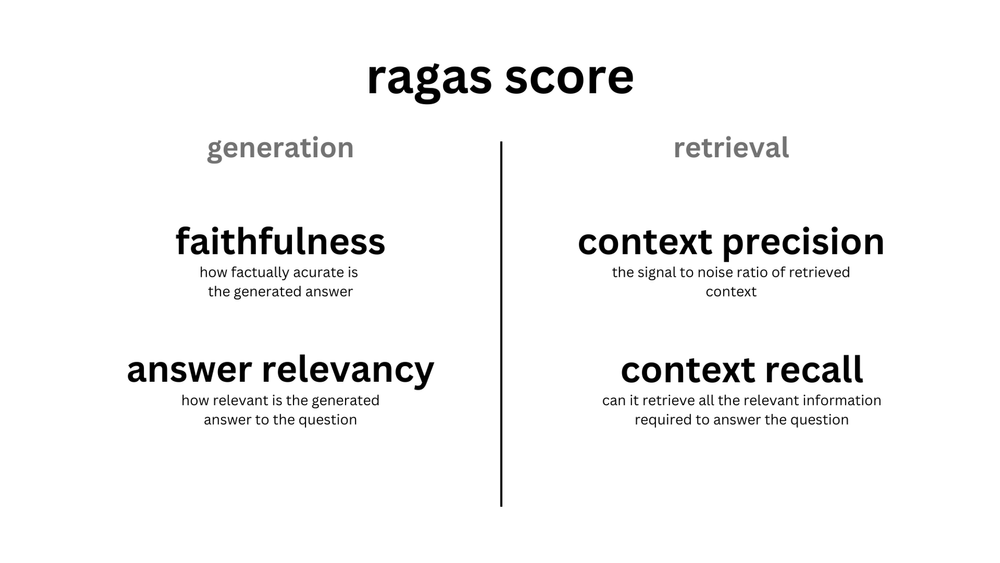

-   `faithfulness`score: 0~1
-   `relevance`score`: 0~1 
-   `precision`score`: 0~1 

`#### 9.1 Create a test dataset`

평가 데이터셋 생성:
    1. 질문생성
    2. 문맥 검색, 답변 생성

In [188]:
def generate_questions(llm, context, num_questions=5):
    prompt = f"""Based on the following context, generate {num_questions} relevant questions that can be answered using the context. 
    Return the questions as a list of strings.

Context:
{context}

Questions:"""
    response = llm.invoke(prompt)
    questions = response.content.strip().split("\n")
    questions = [q.strip() for q in questions if q.strip()]
    return questions[:num_questions]


In [189]:
    # 문맥에서 질문 생성
    sample_context = docs[10].page_content  # 열번째 문서에서 질문생성
    questions = generate_questions(llm, sample_context, num_questions=5)

In [190]:
questions 

['Here are five relevant questions that can be answered using the provided context:',
 "1. **What is the company's investment philosophy, and how does it approach bold investment decisions?**",
 '2. **How does the company prioritize between GAAP accounting and maximizing future cash flows?**',
 '3. **What strategies does the company use to maintain a cost-conscious culture while focusing on growth?**',
 '4. **How did Amazon.com improve its customer experience in 1997, and what new features were introduced?**']

In [234]:
from langchain.chains import RetrievalQA

# RetrievalQA 체인 설정
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=faiss_retriever,
    return_source_documents=True
)

# RAG를 통해 답변 생성 
def generate_answers(retrieval_chain, questions):
    answers = []
    contexts = []
    for question in questions:
        # RetrievalQA 체인을 올바르게 호출
        result = retrieval_chain.invoke({"query": question})
        answers.append(result["result"])
        retrieved_docs = result["source_documents"]
        contexts.append([doc.page_content for doc in retrieved_docs])  # List of strings for Ragas
    return answers, contexts

In [ ]:

# 답변 및 문맥 생성
answers, contexts = generate_answers(qa_chain, questions)

In [ ]:
answers

['1. **What strategies does the company employ to enable a "Why Culture" (high YQ) in its organization?**  \n   - The context mentions that enabling a high YQ (Why Quotient) is not solved by a single mechanism but requires embedding it deeply into the company\'s culture and leadership team. However, specific strategies are not detailed in the provided text.  \n\n2. **Why did the company increase its reserves for liabilities in Q4 2022, and what was the impact?**  \n   - The company increased its reserves by $1.3 billion due to changes in estimates about the costs of asserted and unasserted claims. This adjustment was primarily recorded in "Cost of sales" and impacted the North America segment.  \n\n3. **What legal proceedings is Amazon involved in regarding its Alexa technology?**  \n   - In May 2018, Rensselaer Polytechnic Institute and CF Dynamic Advances LLC filed a complaint alleging that Amazon’s Alexa Voice Software and Alexa-enabled devices infringe U.S. Patent No. 7,177,798.  \

In [ ]:
contexts 

['these were provocative questions that required curiosity, risk-taking, experimentation, and persistence to\nmake these into success stories.\nEnabling a Why Culture\nIf you believe having high YQ is critical to inventing for customers, how do you enable it? In my opinion,\nit’s not solved with one mechanism. It needs to be built deeply into your culture and leadership team, and has\nto be fiercely protected over time if you’re lucky enough to be successful. Here are a few of the strategies\nwe employ.\nliabilities by considering historical claims experience, frequency and costs of claims, projected claims development, inflation, \nand other actuarial assumptions. Changes in the number or costs of claims, healthcare costs, judgment and settlement amounts, \nassociated legal expenses, and other factors could cause actual results to differ materially from these estimates. In the fourth \nquarter of 2022, we increased our reserves for general, product, and automobile liabilities by $1.3 

In [ ]:
    # Ground truth는 예시로 질문에 대한 간단한 참조 답변 생성
    ground_truths = []
    for question in questions:
        prompt = f"Provide a concise and accurate answer to the following question based on the context: \n\n Question: {question}\n\nContext: {sample_context}"
        ground_truth = llm.invoke(prompt).content.strip()
        ground_truths.append(ground_truth)

In [ ]:
ground_truths 

["Here are five relevant questions that can be answered using the provided context:  \n\n1. **What is Amazon's investment philosophy?**  \n   - Amazon prioritizes bold investments for market leadership, values cash flows over GAAP accounting, shares strategic decisions transparently, maintains a lean culture, balances growth with profitability, and emphasizes employee ownership through stock options.  \n\n2. **How does Amazon prioritize customer experience?**  \n   - Amazon obsesses over customers by offering vast selection, convenience (24/7 access, 1-Click shopping), lower prices, and continuous improvements like gift certificates and enhanced recommendations.  \n\n3. **What were Amazon's key achievements in 1997?**  \n   - Sales grew 838% to $147.8M, customer accounts increased 738% to 1.51M, repeat orders rose to 58%, website reach entered the top 20, and strategic partnerships (e.g., AOL, Yahoo!) were established.  \n\n4. **Why does Amazon focus on growth over short-term profitabi

In [230]:
# 4. 데이터셋 생성 및 저장
import pandas as pd
from datasets import Dataset

def create_and_save_dataset(questions, answers, contexts, ground_truths, output_path):
    data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }
    dataset = Dataset.from_pandas(pd.DataFrame(data))
    dataset.save_to_disk(output_path)
    return dataset

In [211]:
    # 데이터셋 생성 및 저장
    output_path = "rag_evaluation_dataset"
    dataset = create_and_save_dataset(questions, answers, contexts, ground_truths, output_path)
    print(f"Dataset saved to {output_path}")
    print(dataset)

Saving the dataset (0/1 shards):   0%|          | 0/5 [00:00<?, ? examples/s]

Dataset saved to rag_evaluation_dataset
Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 5
})


In [233]:
dataset[0]

{'question': 'Here are five relevant questions that can be answered using the provided context:',
 'answer': '1. **What factors contribute to the estimation of Amazon\'s liabilities for claims?**  \n   - Amazon estimates its liabilities by considering historical claims experience, frequency and costs of claims, projected claims development, inflation, and other actuarial assumptions. Changes in these factors could cause actual results to differ materially from estimates.  \n\n2. **Why did Amazon increase its reserves for liabilities in Q4 2022?**  \n   - In Q4 2022, Amazon increased its reserves for general, product, and automobile liabilities by $1.3 billion, primarily due to changes in estimates about the costs of asserted and unasserted claims. This adjustment was recorded in "Cost of sales" and impacted the North America segment.  \n\n3. **What legal proceedings is Amazon currently involved in?**  \n   - Amazon is facing a lawsuit filed by Rensselaer Polytechnic Institute and CF Dy

rm -rf rag_evaluation_dataset

In [ ]:
from datasets import load_from_disk
dataset = load_from_disk("rag_evaluation_dataset")
dataset[0] 

{'question': 'Here are five relevant questions that can be answered using the provided context:',
 'answer': '1. **What factors contribute to the estimation of Amazon\'s liabilities for claims?**  \n   - Amazon estimates its liabilities by considering historical claims experience, frequency and costs of claims, projected claims development, inflation, and other actuarial assumptions. Changes in these factors could cause actual results to differ materially from estimates.  \n\n2. **Why did Amazon increase its reserves for liabilities in Q4 2022?**  \n   - In Q4 2022, Amazon increased its reserves for general, product, and automobile liabilities by $1.3 billion, primarily due to changes in estimates about the costs of asserted and unasserted claims. This adjustment was recorded in "Cost of sales" and impacted the North America segment.  \n\n3. **What legal proceedings is Amazon currently involved in?**  \n   - Amazon is facing a lawsuit filed by Rensselaer Polytechnic Institute and CF Dy

In [221]:
    # 데이터셋 생성 및 저장
    output_path = "rag_evaluation_dataset"
    dataset = create_and_save_dataset(questions, answers, contexts, ground_truths, output_path)
    print(f"Dataset saved to {output_path}")
    print(dataset)

Saving the dataset (0/1 shards):   0%|          | 0/5 [00:00<?, ? examples/s]

Dataset saved to rag_evaluation_dataset
Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 5
})


In [228]:

# 5. Ragas로 데이터셋 평가
def evaluate_dataset(dataset, llm, embeddings):
    result = evaluate(
        dataset=dataset,
        metrics=[
            faithfulness,
            answer_relevancy,
            context_recall,
            context_precision
        ],
        llm=llm,
        embeddings=embeddings
    )
    return result

In [223]:
    # 데이터셋 평가
print("\nEvaluating RAG performance with Ragas...")
evaluation_results = evaluate_dataset(dataset, llm, embedding_huggingface )
print("\nEvaluation Results:")
print(evaluation_results)

# 결과를 CSV로 저장 (선택 사항)
results_df = pd.DataFrame([evaluation_results])
results_df.to_csv("rag_evaluation_results.csv", index=False)
print("Evaluation results saved to rag_evaluation_results.csv")



Evaluating RAG performance with Ragas...


ValidationError: 1 validation error for SingleTurnSample
retrieved_contexts
  Input should be a valid list [type=list_type, input_value='these were provocative q..., advertising, grocery,', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)  
